In [33]:
from pyscf import gto, scf, fci, mcscf
import numpy as np
import matplotlib.pyplot as plt
import qiskit
from qiskit import QuantumCircuit
from matplotlib.ticker import ScalarFormatter
from scipy.optimize import minimize
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
from qiskit_nature.second_q.operators import FermionicOp
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import ParityMapper, JordanWignerMapper, BravyiKitaevMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector
import os
from qiskit import transpile
from qiskit_aer import AerSimulator, AerProvider
from math import comb
import time

from scipy.sparse.linalg import eigsh
from qiskit_ibm_runtime import QiskitRuntimeService


In [34]:
from qiskit_ibm_runtime import QiskitRuntimeService
service = QiskitRuntimeService.save_account(
    token='Wx06bez50boLXEdw3IbqpoDa8gwHcURc9lQT0D_SRxJP', # Your token is confidential.
    # Do not share your key in public code.
    instance="crn:v1:bluemix:public:quantum-computing:us-east:a/624a449c58db4cebbbcd6d44cd96889e:354c61a9-e812-433b-a108-1e267e668f64::",
    name=".", # Optionally name this set of account credentials.
    set_as_default=True, # Optionally set these as your default credentials.
    overwrite=True
  )

In [35]:
#service = QiskitRuntimeService()
#backend = service.backend("ibm_fez")
backend = AerSimulator(method = "statevector",noise_model=None)

In [36]:
def FCI(dist):
    # 1. 분자 정의
    mol = gto.M(
        atom = 'Li 0 0 0; H 0 0 {}'.format(dist),  # 수소 원자 2개, 거리 0.74 Å
        basis = 'sto-3g',              # 간단한 기저함수
        unit = 'Angstrom',
        spin = 0,                      # 전자 수 = 2, 총 spin = 0 (singlet)
        charge = 0
    )

    # 2. Hartree-Fock 계산
    mf = scf.RHF(mol)
    hf_energy = mf.kernel()

    # 3. FCI 계산 (Full CI)
    cisolver = fci.FCI(mol, mf.mo_coeff)
    fci_energy, fci_vector = cisolver.kernel()

    return fci_energy

In [37]:
# 1. 분자 정의 (H₂O)
mol = gto.Mole()
mol.unit = 'Angstrom'
mol.atom = '''
O  0.000000  0.000000  0.000000
H  0.000000  0.757160  0.586260
H  0.000000 -0.757160  0.586260
'''
mol.basis = 'sto-3g'  # 가벼운 basis set (FCI에서는 작은 것이 계산에 적합)
mol.spin = 0          # singlet (모든 전자 paired)
mol.charge = 0
mol.build()

# 2. Hartree–Fock 계산 (reference wavefunction)
mf = scf.RHF(mol)
hf_energy = mf.kernel()

E_nuc = mol.energy_nuc()


# 3. FCI 계산
cisolver = fci.FCI(mol, mf.mo_coeff)
E_FCI, fci_vector = cisolver.kernel()
print(f"FCI Energy    = {E_FCI:.8f} Ha")

converged SCF energy = -74.9629916147475
FCI Energy    = -75.01252080 Ha


In [38]:
def fermion_to_qubit(problem, second_q_op, mapper_name):
    if mapper_name == "JW":
        mapper = JordanWignerMapper()
    if mapper_name == "Pa":
        mapper = ParityMapper(num_particles=problem.num_particles)
    if mapper_name == "BK":
        mapper = BravyiKitaevMapper()
    qubit_op = mapper.map(second_q_op)
    return qubit_op , mapper
    # 고전값 비교용 FCI 
    # H2 인경우로만 해뒀고, 거리 주면 에너지 계산할 수 있음. 
    
def hamming_distance(state1, state2):
    """Number of differing bits"""
    return sum(c1 != c2 for c1, c2 in zip(state1, state2))

def apply_pauli_string(state, pauli_string):
    """
    state: "010101..." (ket)
    pauli_string: "XIZY..."
    
    Returns:
        (new_state, phase factor)
    """
    state_list = list(state)
    phase = 1.0

    for i, p in enumerate(pauli_string):
        if p == 'I':
            continue
        elif p == 'Z':
            if state[i] == '1':
                phase *= -1
        elif p == 'X':
            # X → flip
            state_list[i] = '1' if state[i] == '0' else '0'
        elif p == 'Y':
            # Y → flip + phase
            if state[i] == '0':
                phase *= 1j
            else:
                phase *= -1j
            state_list[i] = '1' if state[i] == '0' else '0'

    new_state = ''.join(state_list)
    return new_state, phase

def inner_product_pauli_hamiltonian(pauli_op, basis_bra, basis_ket):
    """
    Compute <Phi_I | H | Phi_J> using Pauli-mapped Hamiltonian.

    pauli_op: PauliSumOp or similar (e.g. Qiskit's PauliSumOp.to_list())
    basis_bra, basis_ket: "010101..." strings
    
    Returns: float (real part of <bra|H|ket>)
    """
    total = 0.0
    
    # PauliSumOp.to_list() → list of (Pauli string, coeff)
    for pauli_string, coeff in pauli_op.to_list():
        new_state, phase = apply_pauli_string(basis_ket, pauli_string)
        if new_state == basis_bra:
            # term contribute
            total += coeff * phase
    
    return total.real

def project_hamiltonian(basis,hamiltonian):
    n = len(basis)
    H = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            basis_bra = basis[i]
            basis_ket = basis[j]
            inner_product = inner_product_pauli_hamiltonian(hamiltonian, basis_bra , basis_ket)
            H_ij = np.real(inner_product)
            H[i, j] = H_ij 

            #print("<{}|H|{}> = {}".format(basis_bra,basis_ket,H_ij))
    return H 

def particle_count(s):
    n = len(s)
    half = n // 2
    left = s[:half].count('1')
    right = s[half:].count('1')
    return left, right

def flip_one_pair(s, zero_idx, one_idx):
    """
    문자열 s에서 zero_idx는 '0'이어야 하고 → '1'로 바꾸고,
    one_idx는 '1'이어야 하고 → '0'으로 바꿈
    """
    s = list(s)
    assert s[zero_idx] == '0', f"Index {zero_idx} is not 0"
    assert s[one_idx] == '1', f"Index {one_idx} is not 1"
    s[zero_idx] = '1'
    s[one_idx] = '0'
    return ''.join(s)

def one_step_states_constrained(s):
    """1번 연산으로 도달 가능한 상태들 (앞/뒤 particle 수 유지)"""
    zeros = [i for i, c in enumerate(s) if c == '0']
    ones = [i for i, c in enumerate(s) if c == '1']
    target_left, target_right = particle_count(s)

    states = set()
    for zi in zeros:
        for oi in ones:
            if zi == oi:
                continue
            new_s = flip_one_pair(s, zi, oi)
            l, r = particle_count(new_s)
            if l == target_left and r == target_right:
                states.add(new_s)
    return states

def two_step_states_constrained(s):
    """2번 연산으로 도달 가능한 상태들 (앞/뒤 particle 수 유지)"""
    step1 = one_step_states_constrained(s)
    states = set()
    for inter in step1:
        states.update(one_step_states_constrained(inter))
    states.discard(s)  # 자기 자신은 제외
    return states

def calc_total_space(n,k):
    alpha_spin_orbital =int(n/2)
    alpha_electron = int(k/2)
    dim = (comb(alpha_spin_orbital, alpha_electron))**2
    return dim
    

In [ ]:
def Circuit_Preperation(hamiltonian, E_problem,mapper, which_ansatz):
    #헤밀토니안이랑 driver 주어지면, 회로 생성. 
    num_qubits = hamiltonian.num_qubits
    num_particles = E_problem.num_particles
    num_electrons = np.sum(num_particles)
    num_spatial_orbitals = E_problem.num_spatial_orbitals
    init_state = HartreeFock(num_spatial_orbitals,num_particles, mapper)
    if which_ansatz == "uccsd":
        ansatz = UCCSD(num_spatial_orbitals,num_particles,mapper,initial_state=init_state)
    elif which_ansatz == "twolocal": 
        ansatz = TwoLocal(num_spatial_orbitals*2, ['ry', 'rz'], 'cz', initial_state=init_state)
    else : 
        print("ansatz 입력 틀림 uccsd or twolocal ")
    
    return ansatz

def sampling_Filtering(ansatz, parameter, backend, n_ptl):
    # 측정해서 spin이랑 그런거 맞는거만 필터링
    global convergence_state
    global cost_history_dict 
    global repulsion
    global banned_state
    time2 = time.time()

    params = ansatz.parameters 
    param_dict = dict(zip(params, parameter))
    qc = ansatz.assign_parameters(param_dict)
    qc.measure_all()

    job = backend.run(transpile(qc, backend), shots=20000)
    result = job.result()

    # Counts 얻기
    counts = result.get_counts(qc)
    total_shots = sum(counts.values())
    probs = [(bitstring, count / total_shots) for bitstring, count in counts.items()]

    all_basis = []
    all_prob = []

    for bitstring, prob in probs:
        count_ones = bitstring.count('1')
        half = len(bitstring) // 2
        left_ones = bitstring[:half].count('1')
        right_ones = bitstring[half:].count('1')
        if count_ones == n_ptl and left_ones==right_ones :
            all_basis.append(bitstring)
            all_prob.append(prob)

    all_basis = np.array(all_basis)
    #print(len(all_basis))
    all_prob = np.array(all_prob)
        # ... 코드 ...
    
    print("-----------------------")
    print(f"Sampling : {time.time() - time2:.6f}초")
    
    return all_basis

def construct_c_i(all_basis, C_i_1):
    c_i = all_basis | C_i_1
    return c_i    

def screening(all_basis,hamiltonian,k):
    time2 = time.time()
    screened_space = []
    H = project_hamiltonian(all_basis,hamiltonian)
    eigenvalue, eigenvector = eigsh(H, k=1, which='SA')  # SA: smallest algebraic
    
    v0 = eigenvector[:, 0]  # 가장 작은 고유값에 대응하는 고유벡터
    indices = np.argsort(np.abs(v0))[-k:]  # 절댓값 기준으로 큰 순서대로 k개
    important_states = indices[::-1]  # 큰 순서대로 정렬
    
    #print(important_states)
    for idx in important_states:
        screened_basis = all_basis[idx]
        screened_space.append(screened_basis)
        
    print(f"Screening : {time.time() - time2:.6f}초")
    
    return screened_space


def energy_calc(screened_space,hamiltonian):
    time2 = time.time()
    mat = project_hamiltonian(screened_space,hamiltonian)
    eigvals, eigvecs = np.linalg.eigh(mat)
    # 가장 작은 고윳값
    smallest_eigenvalue = eigvals[0]
    smallest_eigvec = eigvecs[0]
    #print("가장 작은 고윳값:", smallest_eigenvalue+repulsion)
    print(f"energy calc: {time.time() - time2:.6f}초")
    
    return smallest_eigenvalue, smallest_eigvec

def post_screening(smallest_eigvec, screened_space, eps):
    time2 = time.time()
    low_contrib_space = []
    low_contrib_indices = np.where(np.abs(smallest_eigvec) < eps)[0]
    for idx in low_contrib_indices:
        low_contrib_state = screened_space[idx]
        low_contrib_space.append(low_contrib_state)
    post_screened_space = list(set(screened_space) - set(low_contrib_space))
    print(f"post screening: {time.time() - time2:.6f}초")
    return post_screened_space 

def classical_expansion(smallest_eigvec,screened_space):
    time2 = time.time()
    max_index = np.argmax(np.abs(smallest_eigvec))
    s = screened_space[max_index]
    s1_constrained = one_step_states_constrained(s)
    s2_constrained = two_step_states_constrained(s)
    #print(s1_constrained)
    #print(s2_constrained)
    excitation_expansion = s1_constrained.union(s2_constrained)
    total_expansion = excitation_expansion.union(screened_space)    
    print(f"calssical expansion: {time.time() - time2:.6f}초")
    return list(total_expansion), list(excitation_expansion)

In [ ]:
class CostWithHistoryList:
    def __init__(self, hamiltonian, ansatz, backend, num_electrons, num_determinant, eps, threshold=1e-4):
        self.prev_list = []
        self.hamiltonian = hamiltonian
        self.ansatz = ansatz
        self.backend = backend
        self.num_electrons = num_electrons
        self.num_determinant = num_determinant
        self.eps = eps

        # 저장소
        self.ith_space = None
        self.expanded_space = None
        self.energy_history = []
        self.iteration = 0
        self.threshold = threshold

        # 수렴 추적용
        self.prev_energies = []
        self.converged_count = 0

        global repulsion

    def __call__(self, parameter):
        time2 = time.time()
        current_list = list(self.compute_current_list(parameter))
        self.prev_list = list(set(self.prev_list + current_list))

        # 에너지 계산
        screened_space = screening(self.prev_list, self.hamiltonian, self.num_determinant)
        Energy, ground_state = energy_calc(screened_space, self.hamiltonian)
        post_screened_space = post_screening(ground_state, screened_space, self.eps)
        

        # 저장
        self.ith_space, self.expanded_space = classical_expansion(ground_state, post_screened_space)
        self.iteration += 1
        self.energy_history.append(Energy)

        # 에너지 변화량 추적
        if self.prev_energies:
            delta = abs(Energy - self.prev_energies[-1])
            if delta < self.threshold:
                self.converged_count += 1
            else:
                self.converged_count = 0

            if self.converged_count >= 3:
        
                print(f"🔚 조기 종료: ΔE < {self.threshold} 가 3회 연속 만족됨.")
                raise StopIteration

        self.prev_energies.append(Energy)

        print(f"each iteration: {time.time() - time2:.6f}초")
        print(f"Iter {self.iteration}: Energy = {Energy + repulsion:.6f}")
        print("-----------------------")
        
        return Energy

    def compute_current_list(self, parameter):
        return sampling_Filtering(self.ansatz, parameter, self.backend, self.num_electrons)

In [41]:
start = time.time()

O = (0.000, 0.000, 0.000)

# O–H bond length
bond_length = 0.9572  # in angstroms
angle_deg = 104.5
angle_rad = np.deg2rad(angle_deg / 2)

# 좌우 대칭 구조로 H 원자 배치
H1 = (bond_length * np.sin(angle_rad), bond_length * np.cos(angle_rad), 0.0)
H2 = (-bond_length * np.sin(angle_rad), bond_length * np.cos(angle_rad), 0.0)

# 최종 입력
atoms = ["O", "H", "H"]
coords = [O, H1, H2]
basis = "sto3g"
charge = 0
multiplicity = 1

Co_O_moleculeinfo = MoleculeInfo(atoms, coords, charge=charge, multiplicity=multiplicity)
driver = PySCFDriver.from_molecule(Co_O_moleculeinfo, basis=basis)
E_problem = driver.run() # 여기는 이후, As_transformer 로 변경. 

num_spin_orbital = 2*E_problem.num_spatial_orbitals
num_particles = E_problem.num_particles
num_electrons = np.sum(num_particles)
print(num_spin_orbital)
print(num_electrons)
total_dim = calc_total_space(num_spin_orbital,num_electrons)

# Transformer 적용
#E_problem = active_transformer.transform(problem)


# 여기는 이후, As_transformer 로 변경. 
fermionic_hamiltonian = E_problem.hamiltonian
repulsion = fermionic_hamiltonian.constants['nuclear_repulsion_energy']
second_q_op = fermionic_hamiltonian.second_q_op()
hamiltonian,mapper = fermion_to_qubit(E_problem, second_q_op, "JW")
print(total_dim)


time1 = time.time() #헤밀토니안 구성
# ... 코드 ...
print(f"Part 1 시간: {time.time() - time1:.6f}초")


14
10
441
Part 1 시간: 0.000023초


In [42]:
eps = 10**(-5)
k = 100
ansatz = Circuit_Preperation(hamiltonian, E_problem,mapper, "uccsd")
num_particles = E_problem.num_particles
num_electrons = np.sum(num_particles)

num_params = ansatz.num_parameters
x0 = 2 * np.pi * np.random.random(num_params)

cost_func = CostWithHistoryList(
    hamiltonian=hamiltonian,
    ansatz=ansatz,
    backend=backend,
    num_electrons=num_electrons,
    num_determinant=k,
    eps=eps
)


try:
    res = minimize(
        cost_func,
        x0,
        method="cobyla",
        options={"maxiter": 20, "disp": True}
    )
    
except StopIteration:
    print("⚠️ Optimization stopped early due to convergence criteria.")

Sampling : 0.920410초
Screening : 101.840464초
energy calc: 31.916299초
post screening: 0.000084초
calssical expansion: 0.001590초
Iter 1: Energy = -73.993758
each iteration: 134.679569초
Sampling : 1.029231초
Screening : 152.056483초
energy calc: 31.429021초
post screening: 0.000078초
calssical expansion: 0.001673초
Iter 2: Energy = -73.994037
each iteration: 184.517179초
Sampling : 1.043118초
Screening : 169.933607초
energy calc: 31.866615초
post screening: 0.000079초
calssical expansion: 0.001877초
Iter 3: Energy = -74.025358
each iteration: 202.846051초
Sampling : 1.040533초
Screening : 218.348933초
energy calc: 31.651014초
post screening: 0.000081초
calssical expansion: 0.001628초
Iter 4: Energy = -74.025613
each iteration: 251.045084초
Sampling : 1.031183초
Screening : 253.145511초
energy calc: 31.607281초
post screening: 0.000064초
calssical expansion: 0.001469초
Iter 5: Energy = -74.093294
each iteration: 285.786329초
Sampling : 1.003300초
Screening : 300.384324초
energy calc: 31.557419초
post screening: 0.000

capi_return is NULL
Call-back cb_calcfc_in__cobyla__user__routines failed.
Traceback (most recent call last):
  File "/opt/miniconda3/envs/hivqe/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3672, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/mq/vvzpq4_16092g__xg10fscp80000gn/T/ipykernel_5444/4231838378.py", line 21, in <module>
    res = minimize(
          ^^^^^^^^^
  File "/opt/miniconda3/envs/hivqe/lib/python3.11/site-packages/scipy/optimize/_minimize.py", line 744, in minimize
    res = _minimize_cobyla(fun, x0, args, constraints, callback=callback,
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/hivqe/lib/python3.11/site-packages/scipy/optimize/_cobyla_py.py", line 35, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/opt/miniconda3/envs/hivqe/lib/python3.11/site-packages/scipy/optimize/_cobyla_py.py", line 293, in _minimize_co

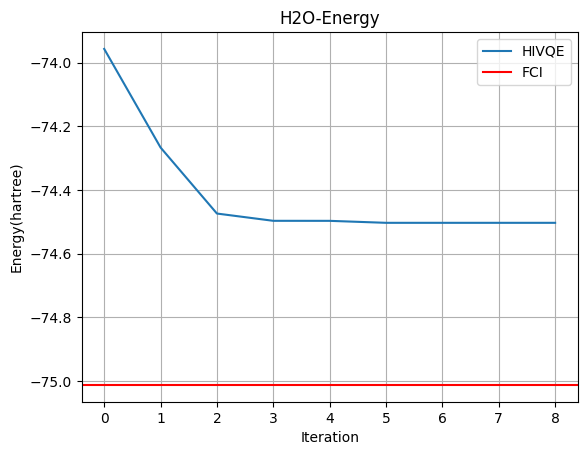

In [ ]:
plt.plot(cost_func.energy_history+repulsion, label = "HIVQE")
#plt.axhline(E_HF, label = "HF")
plt.axhline(E_FCI, color ='r',label = "FCI")
plt.title("H2O-Energy")
plt.xlabel("Iteration")
plt.ylabel("Energy(hartree)")
plt.legend()
plt.grid()
plt.show()

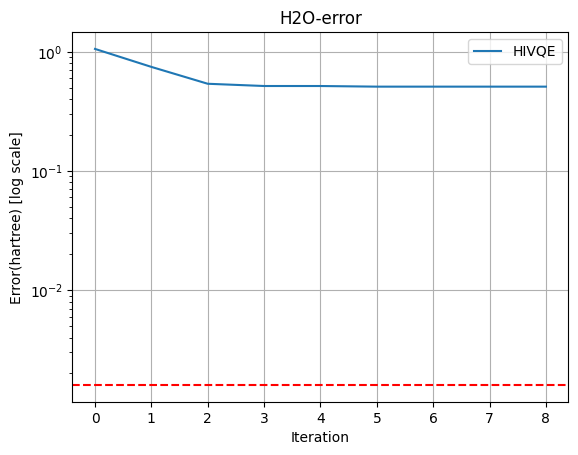

In [ ]:
Chem_accuracy = 0.0016

plt.plot(cost_func.energy_history+repulsion - E_FCI, label = "HIVQE")
plt.axhline(Chem_accuracy,color = 'red',ls= '--')
plt.yscale("log")
plt.title("H2O-error")
plt.xlabel("Iteration")
plt.ylabel("Error(hartree) [log scale]")
plt.legend()
plt.grid()
plt.show()